<a href="https://colab.research.google.com/github/Olin-RoboSys/test-colab/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 1: 2D Color Image Processing

### Goals:
1. Students build an intuition about digital image representation
2. Students are able to use existing Python libraries to perform basic image processing operations
3. Students can develop an image processing pipeline to perform main tasks:
  - Image classification
  - Segmentation (semantic, instance)
  - Object detection
4. Students can evaluate the performance of image processing pipeline to inform pipeline improvements

## Section 1: Images as Arrays

We define how images are represented as arrays

Import relevant Python packages

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

Load and display an image

In [ ]:
path_to_image = 'orange.png'

# read the image from the directory
img = cv.imread(path_to_image)

In [ ]:
# display the image array

print(img)
print(img[0,0])

[[[16 30  6]
  [42 54 36]
  [43 54 46]
  ...
  [ 1 29  0]
  [ 0 28  0]
  [ 0 28  0]]

 [[30 58 29]
  [34 54 35]
  [54 70 59]
  ...
  [ 0 27  1]
  [ 0 28  0]
  [ 0 28  0]]

 [[ 0 29  1]
  [15 46 25]
  [53 71 58]
  ...
  [ 0 27  1]
  [ 0 28  0]
  [ 0 28  0]]

 ...

 [[50 82 57]
  [51 88 62]
  [55 98 71]
  ...
  [50 67 34]
  [55 71 40]
  [53 71 40]]

 [[53 87 63]
  [51 87 63]
  [57 98 71]
  ...
  [51 66 34]
  [55 71 40]
  [53 71 40]]

 [[60 96 74]
  [60 96 72]
  [58 98 70]
  ...
  [51 66 34]
  [55 70 42]
  [56 76 47]]]
[16 30  6]


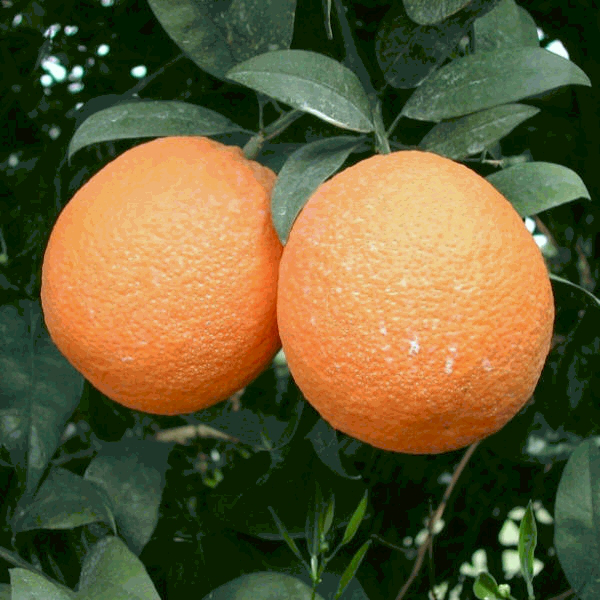

In [ ]:
# display the image
cv2_imshow(img)

Image data shape: (15, 15, 3)


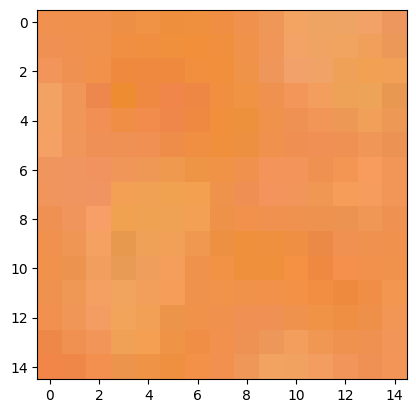

In [ ]:
# cropping the array

img_cropped = img[285:300, 285:300].copy()
img_cropped_rgb = cv.cvtColor(img_cropped, cv.COLOR_BGR2RGB)
plt.imshow(img_cropped_rgb)
print(f'Image data shape: {img_cropped_rgb.shape}')

In [ ]:
# inspect the data type and shape
print('OpenCV image data type:', type(img))
print(f'Image data shape: {img.shape}')

OpenCV image data type: <class 'numpy.ndarray'>
Image data shape: (600, 600, 3)


In [ ]:
# convert from BGR -> RGB for sake of matplotlib
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

3


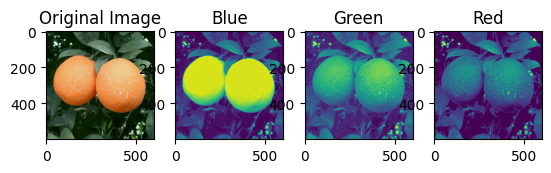

In [ ]:
# split image into respective channels

channels = cv.split(img_rgb)
print(len(channels))
titles = ['Original Image', 'Blue', 'Green', 'Red']

plt.subplot(1,4,1)
plt.imshow(img_rgb), plt.title(titles[0])

for i in range(len(channels)):
    plt.subplot(1,4,i+2)
    plt.imshow(channels[i])
    plt.title(titles[i+1])

plt.show()

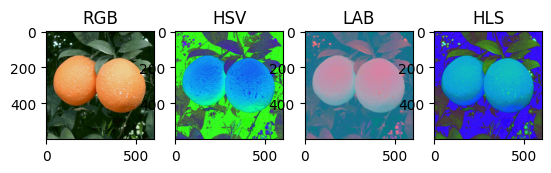

In [ ]:
# change to different color spaces

img_hsv = cv.cvtColor(img_rgb, cv.COLOR_RGB2HSV)
img_lab = cv.cvtColor(img_rgb, cv.COLOR_RGB2LAB)
img_hls = cv.cvtColor(img_rgb, cv.COLOR_RGB2HLS)

titles = ['RGB', 'HSV', 'LAB', 'HLS']
imgs = [img_hsv, img_lab, img_hls]

plt.subplot(1,4,1)
plt.imshow(img_rgb), plt.title(titles[0])

for i in range(len(imgs)):
    plt.subplot(1,4,i+2)
    plt.imshow(imgs[i])
    plt.title(titles[i+1])

plt.show()

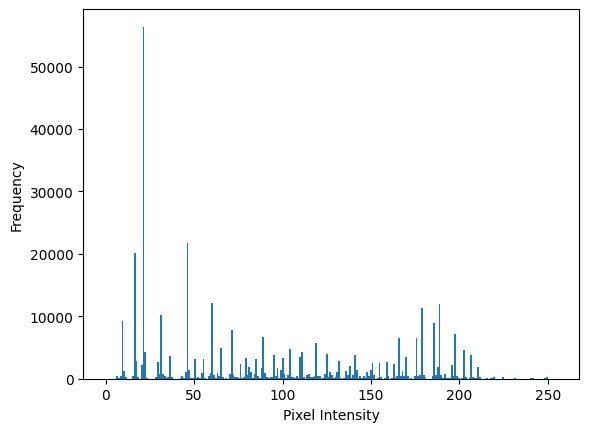

In [ ]:
# Evaluate image histograms
# reference: https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html

# convert image to grayscale
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# cv2_imshow(img_gray)

histSize = 256
histRange = (0, 255)
# hist = cv.calcHist([img_gray], [0], None, [histSize], histRange)
# plt.plot(hist)

plt.hist(img_gray.flatten(), bins=histSize, range=histRange, alpha=1)
# plt.title('Histogram of Grayscale Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


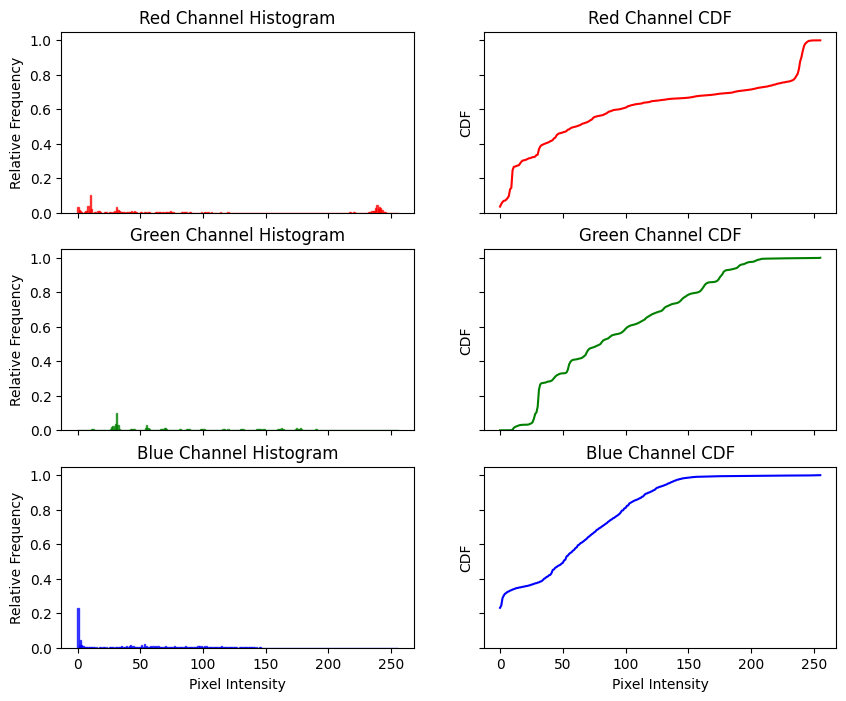

In [ ]:
# plot histogram for all three channels of RGB image

# Initialize figure and axis
fig, axes = plt.subplots(3, 2, figsize=(10, 8), sharex='col', sharey='row')
colors = ['red', 'green', 'blue']
channel_names = ['Red', 'Green', 'Blue']

for i, color in enumerate(colors):
    # Calculate the histogram for each channel
    hist, bins = np.histogram(img_rgb[..., i], bins=256, range=(0, 256))

    # Normalize the histogram to get relative frequency
    hist = hist / hist.sum()

    # Calculate the CDF
    cdf = np.cumsum(hist)

    # Plot the histogram
    axes[i, 0].bar(bins[:-1], hist, width=1, edgecolor=color, color=color, alpha=0.7)
    axes[i, 0].set_title(f'{channel_names[i]} Channel Histogram')
    axes[i, 0].set_ylabel('Relative Frequency')

    # Plot the CDF
    axes[i, 1].plot(bins[:-1], cdf, color=color)
    axes[i, 1].set_title(f'{channel_names[i]} Channel CDF')
    axes[i, 1].set_ylabel('CDF')

# Set common labels
axes[-1, 0].set_xlabel('Pixel Intensity')
axes[-1, 1].set_xlabel('Pixel Intensity')

# plt.tight_layout()
plt.show()

## Section 2: Image Enhancement

### Histogram Equalization


In [ ]:
# Histogram equalization
# references:
# - https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
# - https://www.sci.utah.edu/~acoste/uou/Image/project1/Arthur_COSTE_Project_1_report.html

path_to_image = 'orange2.jpg'

# read the image from the directory
img = cv.imread(path_to_image)

# cv2_imshow(img)
img.shape

(360, 640, 3)

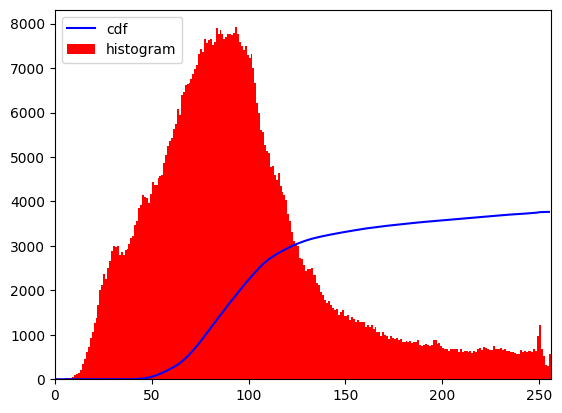

In [ ]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

hist,bins = np.histogram(img_gray.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

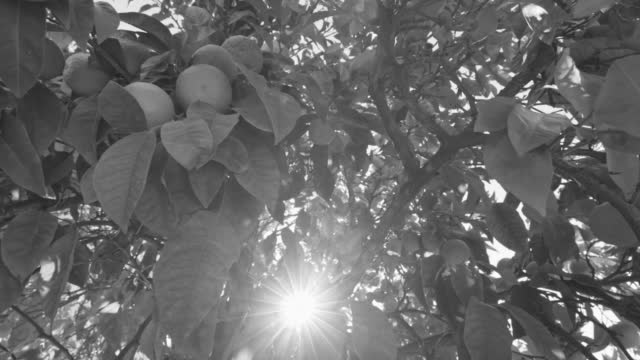

In [ ]:
cv2_imshow(img_gray)

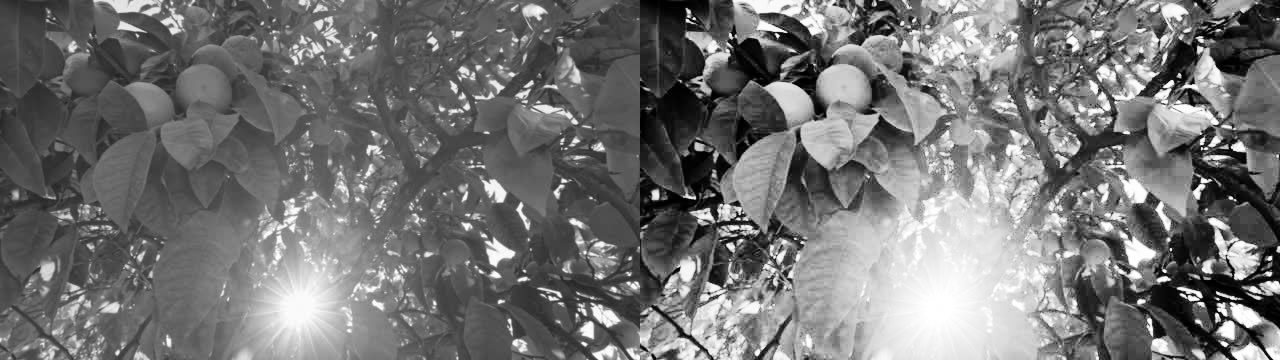

In [ ]:
dst = cv.equalizeHist(img_gray)
res = np.hstack((img_gray, dst)) #stacking images side-by-side
cv2_imshow(res)

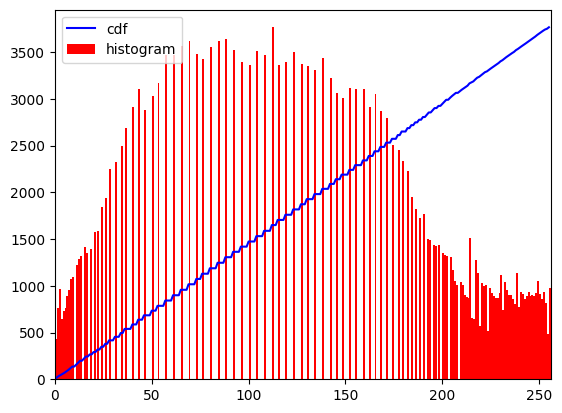

In [ ]:
hist, bins = np.histogram(dst.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(dst.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

### Filtering

## Section 3: Segmentation

### Pixel-Wise Segmentation

1. Threshold-based using a manual approach

2. Otsu thresholding

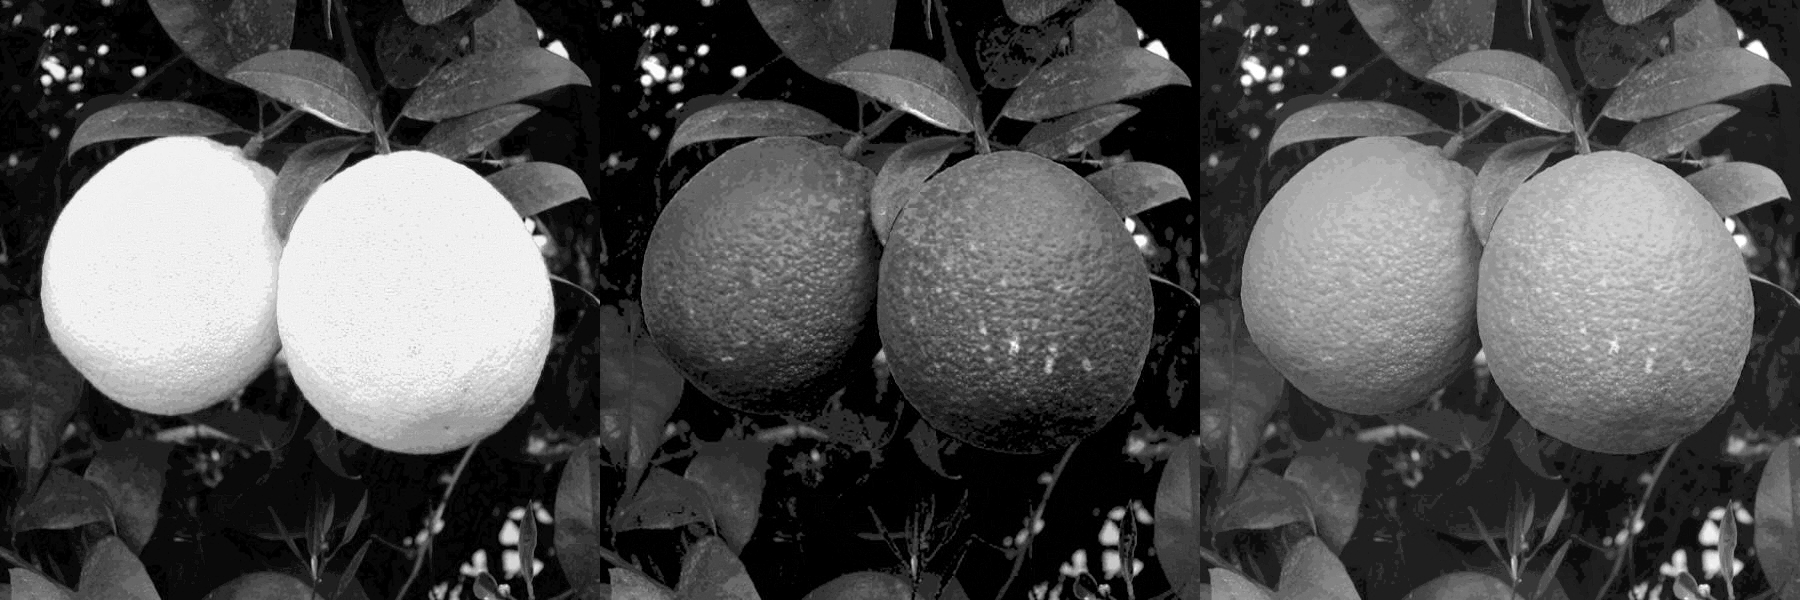

In [ ]:
# Manual approach

path_to_image = 'orange.png'

# read the image from the directory
img = cv.imread(path_to_image)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

red, blue, green = cv.split(img_rgb)
res = np.hstack((red, green, blue))
cv2_imshow(res)

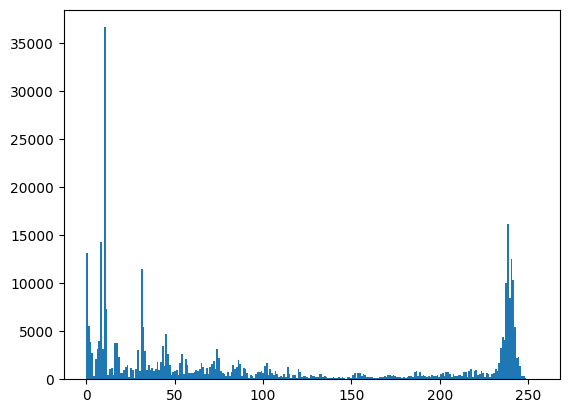

In [ ]:
# get the histogram

plt.hist(red.flatten(), bins=256)
plt.show()

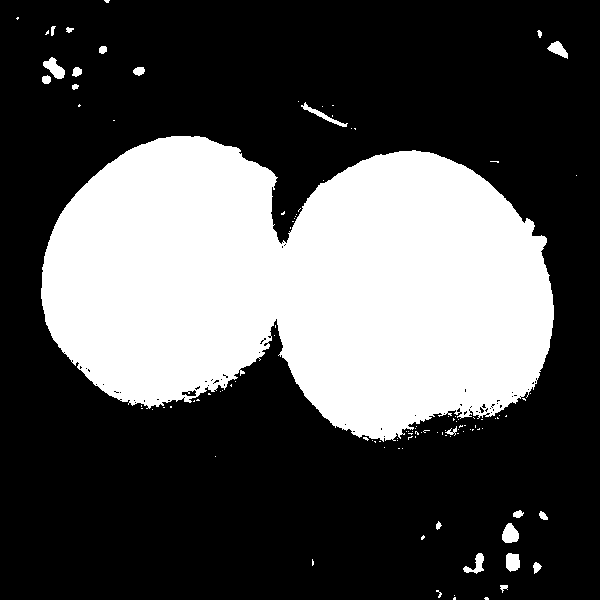

In [ ]:
mask = red > 160
# cv2_imshow(mask)
mask = mask.astype(np.uint8) * 255
cv2_imshow(mask)

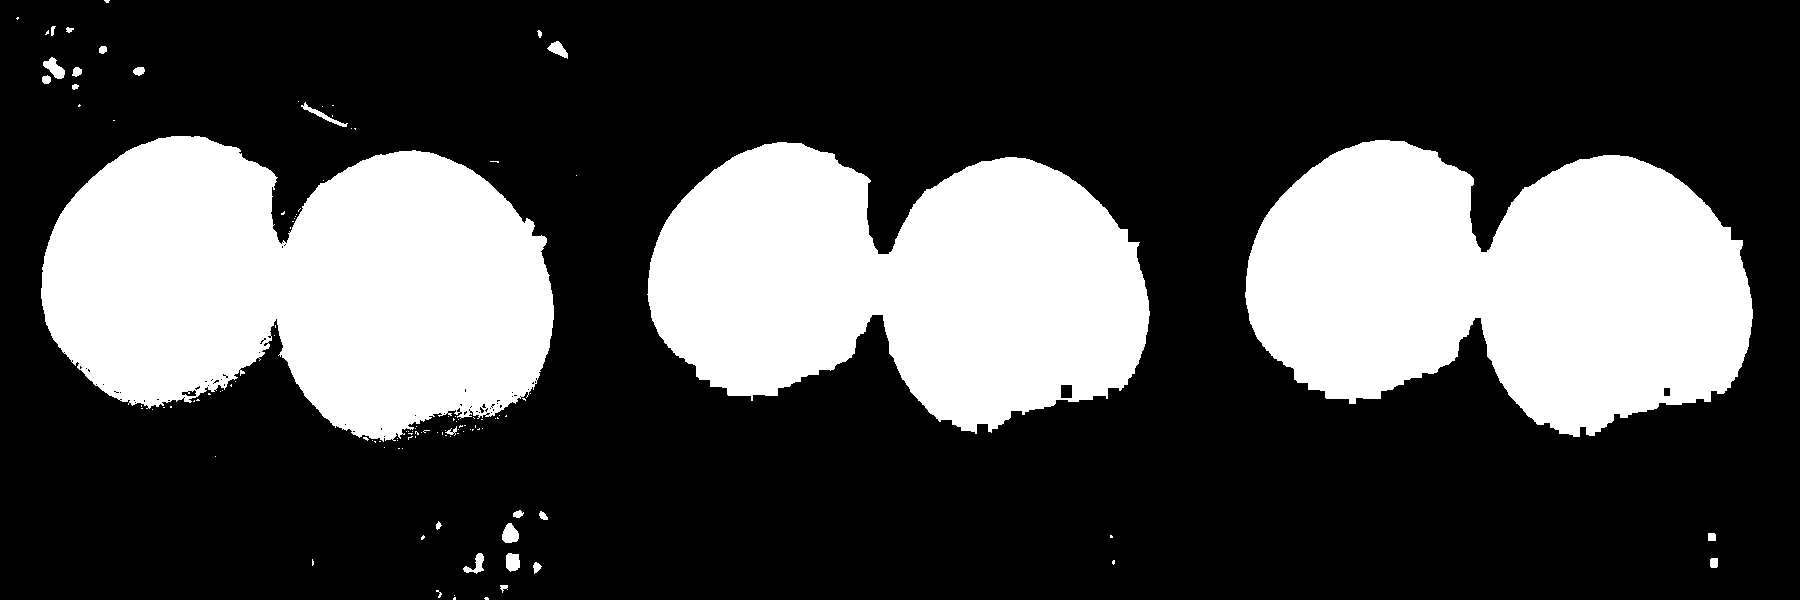

In [ ]:
# erosion
kernel = np.ones((6,6), np.uint8)
mask_eroded = cv.erode(mask, kernel, iterations=2)
# cv2_imshow(mask_eroded)

# dilation
mask_dilated = cv.dilate(mask_eroded, kernel, iterations=1)
# cv2_imshow(mask_dilated)

res = np.hstack((mask, mask_eroded, mask_dilated))
cv2_imshow(res)

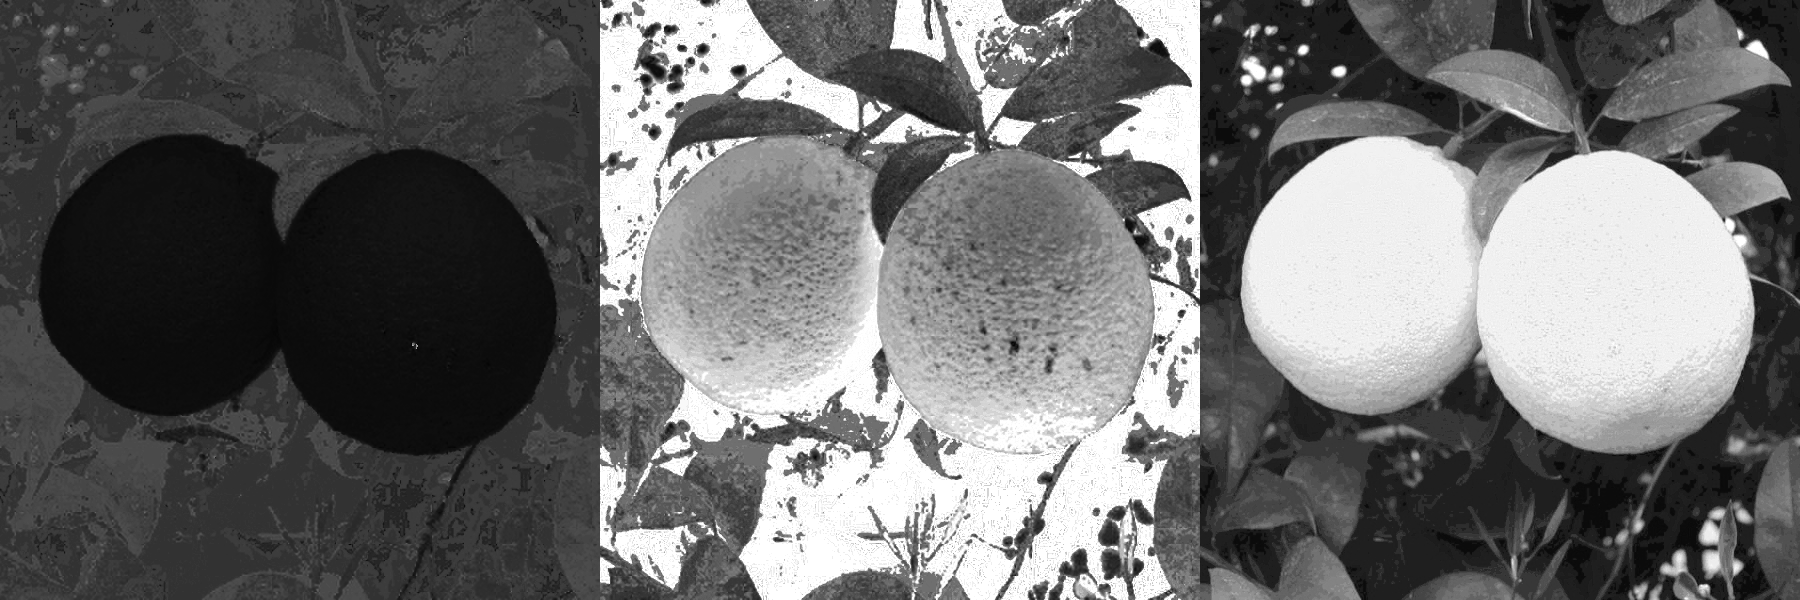

In [ ]:
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

hue, saturation, value = cv.split(img_hsv)
res = np.hstack((hue, saturation, value))
cv2_imshow(res)

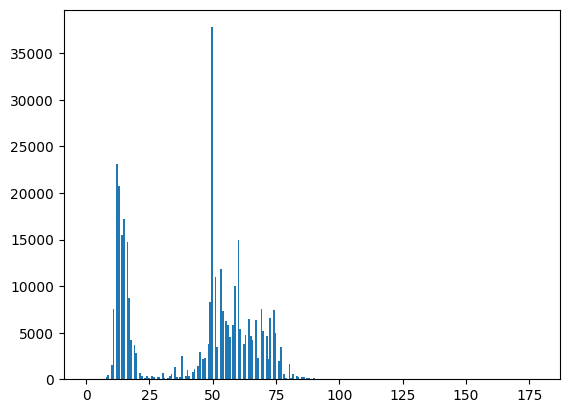

In [ ]:
# get the histogram
plt.hist(hue.flatten(), bins=256)
plt.show()

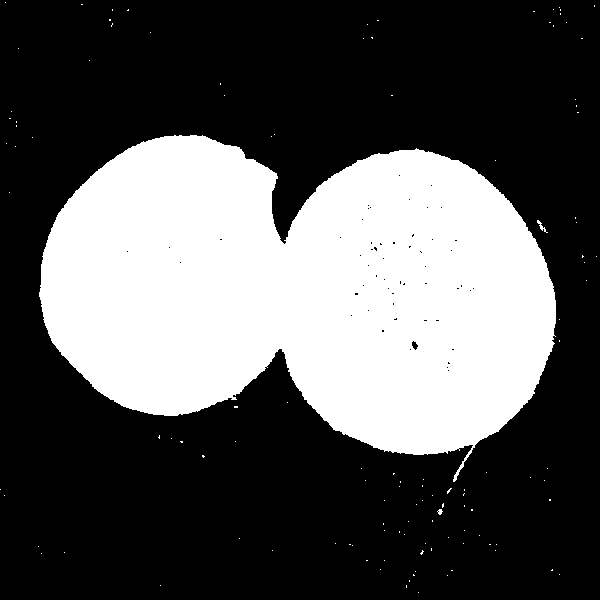

In [ ]:
mask = hue < 22
mask = mask.astype(np.uint8) * 255
cv2_imshow(mask)

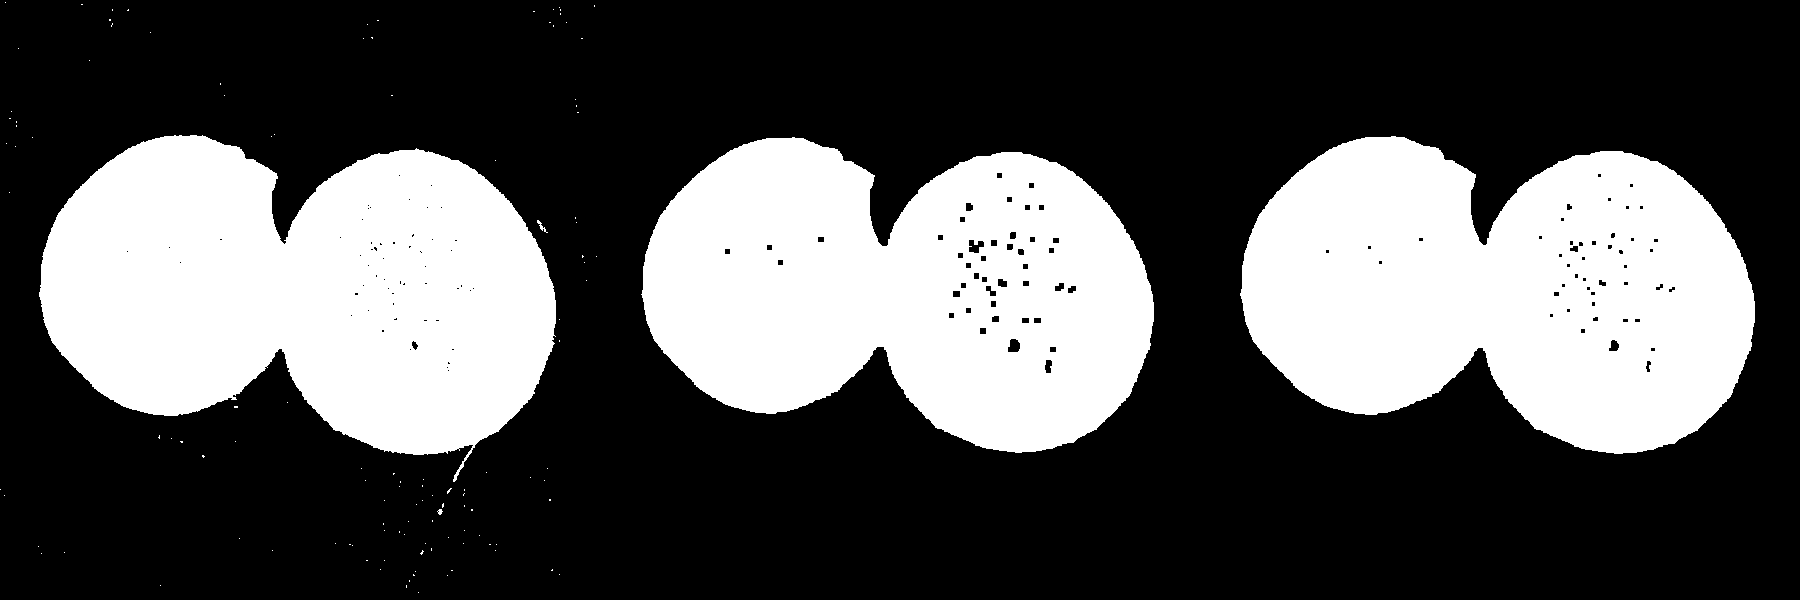

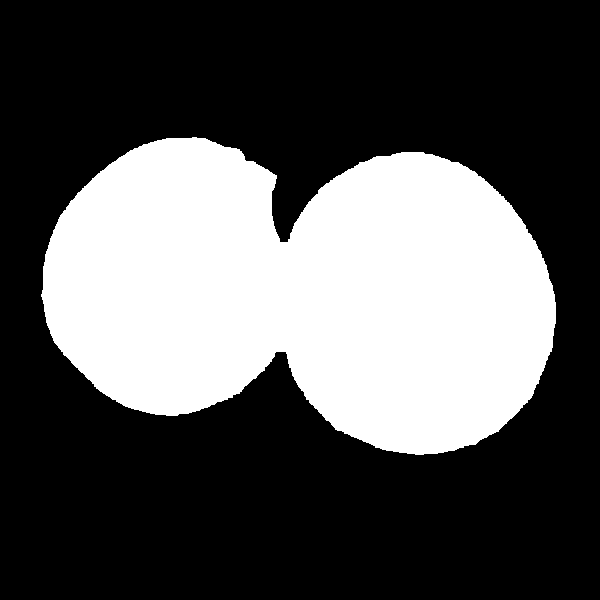

In [ ]:
# erosion
kernel = np.ones((3,3), np.uint8)
mask_eroded = cv.erode(mask, kernel, iterations=2)
# cv2_imshow(mask_eroded)

# dilation
mask_dilated = cv.dilate(mask_eroded, kernel, iterations=1)
# cv2_imshow(mask_dilated)

# closing
closing_kernel = np.ones((8,8), np.uint8)
mask_closed = cv.morphologyEx(mask_dilated, cv.MORPH_CLOSE, closing_kernel)

res = np.hstack((mask, mask_eroded, mask_dilated))
cv2_imshow(res)

cv2_imshow(mask_closed)

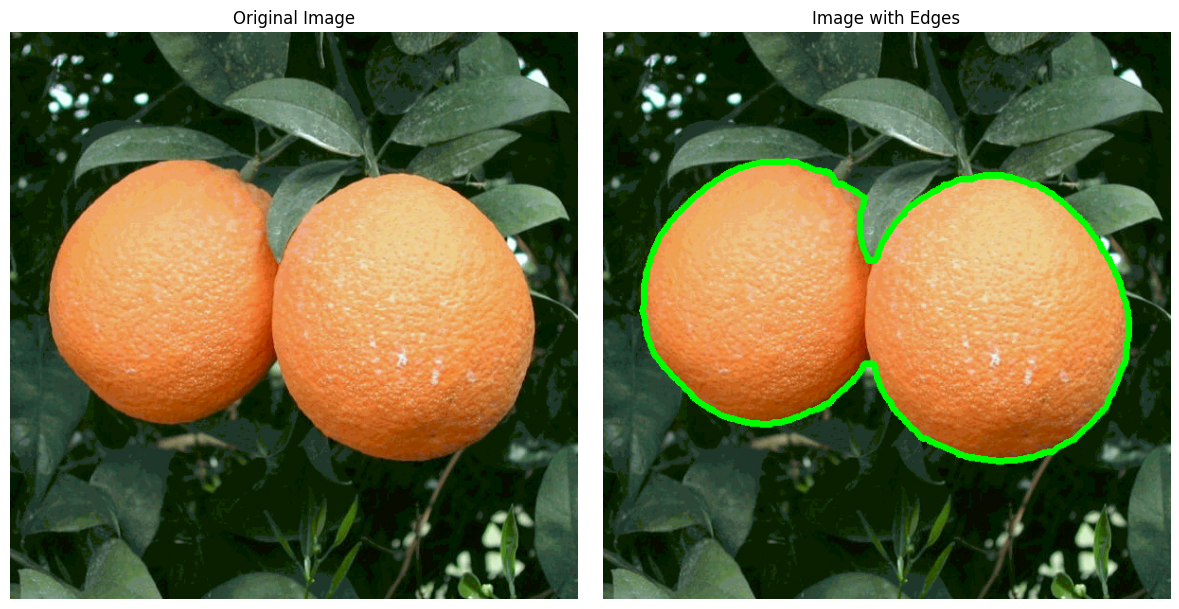

In [ ]:
# edge detection

# Perform Canny edge detection
# edges = cv.Canny(mask_closed, threshold1=100, threshold2=200)

# Create a copy of the original image to draw edges
image_with_edges = img_rgb.copy()

# Find contours from the edges
contours, _ = cv.findContours(mask_closed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv.drawContours(image_with_edges, contours, -1, (0, 255, 0), 5)

# Plot the original image and the image with edges
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(image_with_edges)
axes[1].set_title('Image with Edges')
axes[1].axis('off')

plt.tight_layout()
plt.show()